In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import pickle
from collections import defaultdict
from math import sqrt
import colorsys
import numpy as np
import pylab as pl

In [3]:
edge_counts = defaultdict(int)
file =  open('../reddit_v2.txt') 
nodes_name = set()
for line in file:
    node_list = line.rstrip().split()
    edge_counts[node_list[0]] += 1
    nodes_name.add(node_list[0])
file.close()

print("Average number of edges", sum(edge_counts.values()) / len(edge_counts))
print("Number of edges", sum(edge_counts.values()))
print("Number of nodes", len(nodes_name))

<IPython.core.display.Javascript object>


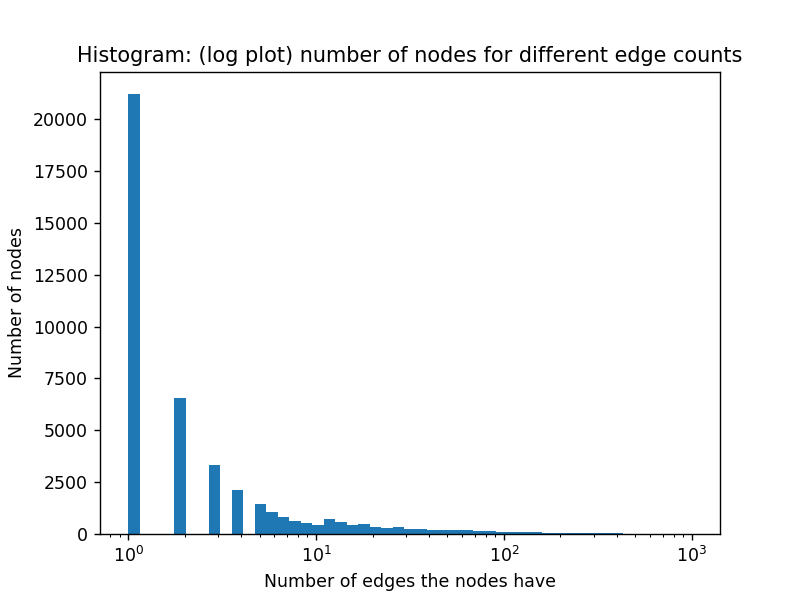

In [5]:
all_counts = list(edge_counts.values())
pl.figure()
pl.hist(all_counts, bins = np.logspace(np.log10(1), np.log10(1000), 50))
pl.gca().set_xscale("log")
pl.title("Histogram: (log plot) number of nodes for different edge counts")
pl.ylabel("Number of nodes"); pl.xlabel("Number of edges the nodes have")
pl.show()
# _ = plt.hist(a[:1000], bins = np.logspace(np.log10(min_val + 1), np.log10(max_val), 50))  # arguments are passed to np.histogram

<IPython.core.display.Javascript object>


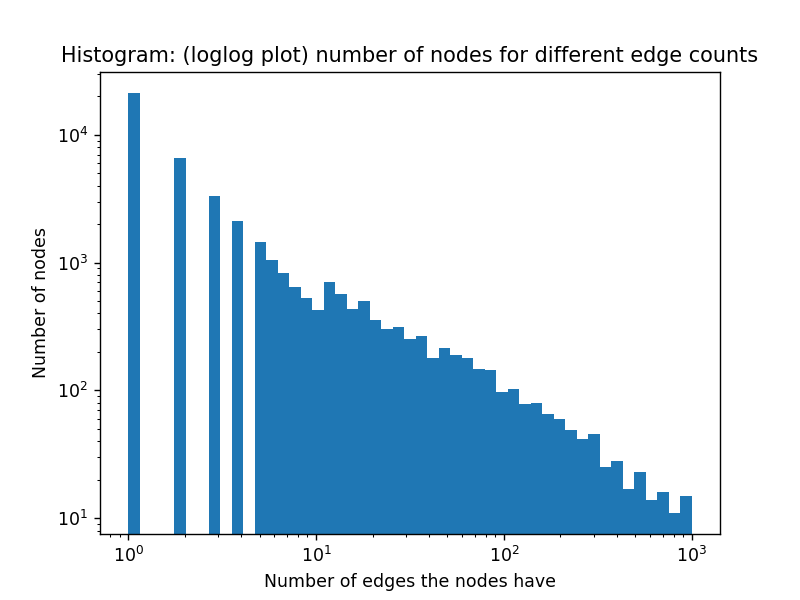

In [6]:
pl.figure()
pl.hist(all_counts, bins = np.logspace(np.log10(1), np.log10(1000), 50))
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.title("Histogram: (loglog plot) number of nodes for different edge counts")
pl.ylabel("Number of nodes"); pl.xlabel("Number of edges the nodes have")
pl.show()

In [11]:
edges_cutoff = 1
edges_subset = []
edges_signs = []
nodes_name = set()
file =  open('../reddit_v2.txt') 
for line in file:
    node_list = line.rstrip().split()
    if edge_counts[node_list[0]] >= edges_cutoff and edge_counts[node_list[1]] >= edges_cutoff:
        edges_subset.append((node_list[0], node_list[1]))
        edges_signs.append(node_list[2])
        for node in node_list[:1]:
            nodes_name.add(node)
file.close()

all_counts = [edge_counts[key] for key in edge_counts]
print("After cutting of nodes with less connections:")
print("Number of edges", len(edges_subset))
print("Number of nodes", len(nodes_name))

new_edge_counts = defaultdict(int)
for node in nodes_name:
    new_edge_counts[node] += edge_counts[node]

print(len(nodes_name))
print(len(edges_subset))

G = nx.Graph()
G.add_nodes_from(nodes_name)
G.add_edges_from(edges_subset)

After cutting of nodes with less connections:
Number of edges 491535
Number of nodes 39352
39352
491535


In [12]:
# find largest connected component
# cc = [G.subgraph(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]

In [13]:
# edges
# nx.draw_networkx_edges(G, pos, width = 1.0, alpha = 0.5)
signed_edges = zip(edges_signs, edges_subset)
sorted_edges = list(signed_edges)
sorted_edges.sort()
neg_count = sorted_edges.index(next(filter(lambda x: x[0] != '-1', sorted_edges)))  
graph_edges = [x[1] for x in sorted_edges]
neg_edges = graph_edges[:neg_count]
pos_edges = graph_edges[neg_count:]

In [14]:
communities_greedy_mod = community.greedy_modularity_communities(G)
print("Number of communities:", len(communities_greedy_mod))

Number of communities: 411


In [30]:
pickle.dump(communities_greedy_mod, open("../cluster_data/data_viz_comms.pkl", "wb" ))

In [15]:
community_labels = defaultdict(int)
community_sizes  = defaultdict(int)
for node in nodes_name:
    count = 0
    for cluster in communities_greedy_mod:
        if node in cluster:
            community_labels[node] = count
            community_sizes[count] += 1
        count += 1
print(sorted_edges[0])

# for x in neg_edges:
#     print(x)
#     print(x[0], community_labels[x[0]])
#     print(x[1], community_labels[x[1]])
#     break

neg_edge_same_community = [(x[0], x[1]) for x in neg_edges \
                          if community_labels[x[0]] == community_labels[x[1]]]
neg_edge_diff_community = [(x[0], x[1]) for x in neg_edges \
                          if community_labels[x[0]] != community_labels[x[1]]]
pos_edge_same_community = [(x[0], x[1]) for x in pos_edges \
                          if community_labels[x[0]] == community_labels[x[1]]]
pos_edge_diff_community = [(x[0], x[1]) for x in pos_edges \
                          if community_labels[x[0]] != community_labels[x[1]]]

print(len(neg_edge_same_community))
print(len(neg_edge_diff_community))
print(len(pos_edge_same_community))
print(len(pos_edge_diff_community))

('-1', ('1200isjerky', '1200isplenty'))


<IPython.core.display.Javascript object>


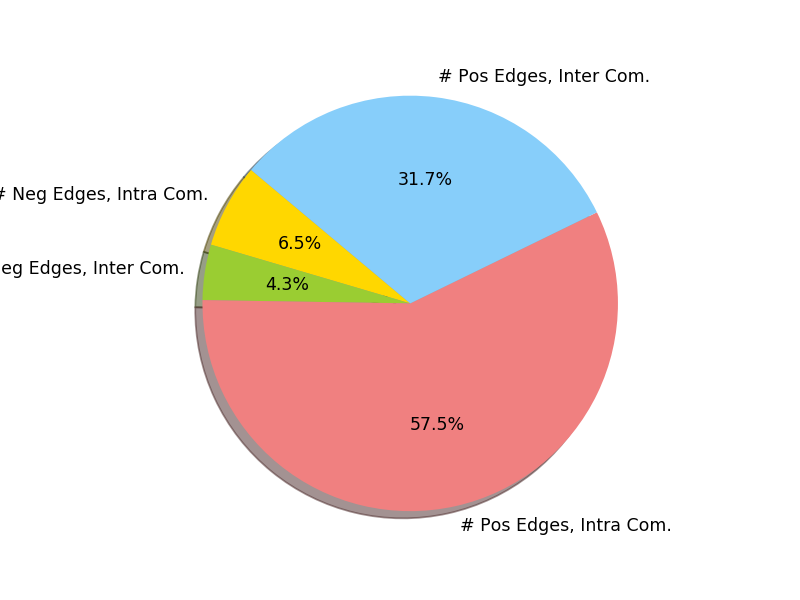

In [18]:
# Plot
labels  = ["# Neg Edges, Intra Com.", "# Neg Edges, Inter Com."]
labels += ["# Pos Edges, Intra Com.", "# Pos Edges, Inter Com."]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
sizes   = [len(neg_edge_same_community), len(neg_edge_diff_community)]
sizes  += [len(pos_edge_same_community), len(pos_edge_diff_community)]
explode = (0, 0, 0, 0)
plt.figure()
plt.pie(sizes, explode = explode, labels = labels, colors = colors,
autopct='%1.1f%%', shadow = True, startangle = 140)
# pl.title("Dist of Edges")
plt.axis('equal')
plt.show()

In [19]:
inter_community_edges = []
pos_comm_nodes = set()
for edge in pos_edges:
    comm1 = community_labels[edge[0]]
    comm2 = community_labels[edge[1]]
    pos_comm_nodes.update((comm1, comm2))
    inter_community_edges.append((comm1, comm2))
pos_comm_nodes = list(pos_comm_nodes)
pos_comm_edges = inter_community_edges

inter_community_edges = []
neg_comm_nodes = set()
for edge in neg_edges:
    comm1 = community_labels[edge[0]]
    comm2 = community_labels[edge[1]]
    neg_comm_nodes.update((comm1, comm2))
    inter_community_edges.append((comm1, comm2))
neg_comm_nodes = list(neg_comm_nodes)
neg_comm_edges = inter_community_edges

In [20]:
G_neg = nx.Graph()
G_neg.add_nodes_from(neg_comm_nodes)
G_neg.add_edges_from(neg_comm_edges)

G_pos = nx.Graph()
G_pos.add_nodes_from(pos_comm_nodes)
G_pos.add_edges_from(pos_comm_edges)

# Network Graphs Communites as Nodes

In [32]:
# N = 5
# HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
# RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
# RGB_tuples = list(RGB_tuples)

colors = ['aqua','blue','coral','crimson','cyan','fuchsia','green','grey',\
          'indigo','lightblue','lime','magenta','orangered','pink','teal',\
          'violet','yellow','olive','maroon','khaki']

def draw_nodes(G, counts_sum, node_list):
    count = -1
    nx.draw_networkx_nodes(G, pos, k = 1/sqrt(len(nodes_name) * 100),
       nodelist = node_list,
       node_color = 'blue',
#        node_size = [community_sizes[key] / counts_sum for key in community_sizes],
       node_size = 10,
       alpha = 0.8)

<IPython.core.display.Javascript object>


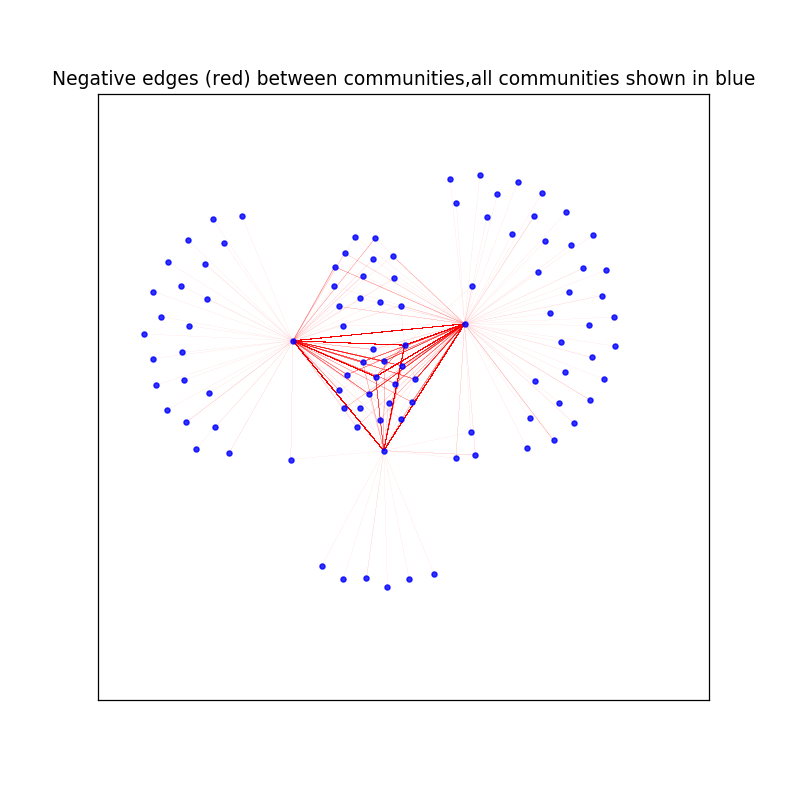

Text(0.5, 1.0, 'Negative edges (red) between communities,all communities shown in blue')

In [33]:
pos = nx.spring_layout(G_neg)  # positions for all nodes
counts_sum = len(neg_comm_edges) / 1000000
plt.figure(figsize = (7, 7)) 
draw_nodes(G_neg, counts_sum, neg_comm_nodes)
nx.draw_networkx_edges(G_neg, pos,
                       edgelist = neg_comm_edges,
                       width = 0.05, alpha = 0.5, edge_color = 'r')
plt.title("Negative edges (red) between communities,\
all communities shown in blue")

<IPython.core.display.Javascript object>


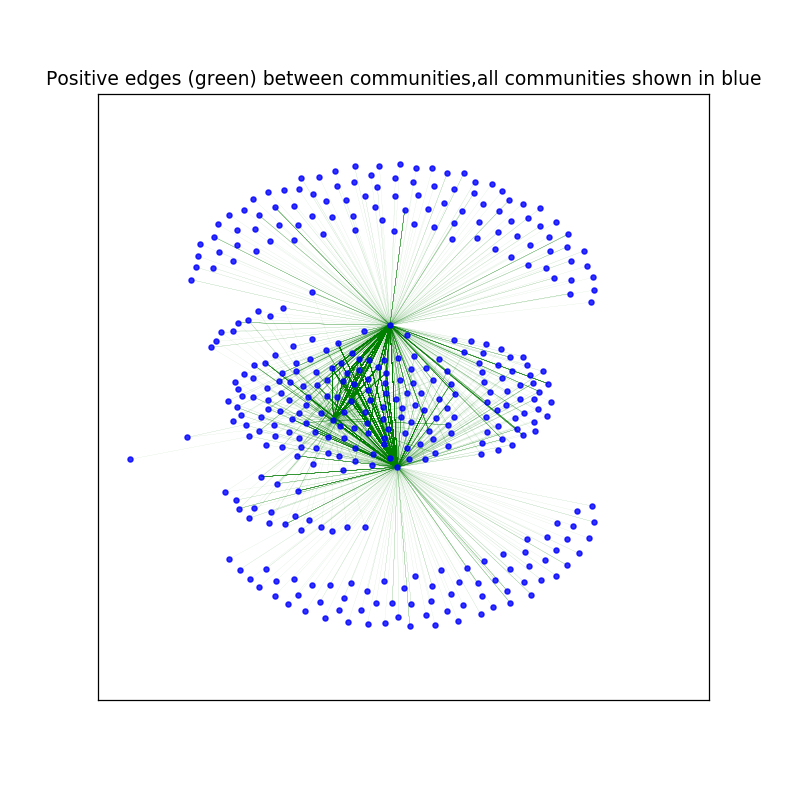

Text(0.5, 1.0, 'Positive edges (green) between communities,all communities shown in blue')

In [34]:
pos = nx.spring_layout(G_pos)  # positions for all nodes
counts_sum = len(pos_comm_edges) / 1000000
plt.figure(figsize = (7, 7)) 
draw_nodes(G_pos, counts_sum, pos_comm_nodes)
nx.draw_networkx_edges(G_pos, pos,
                       edgelist = pos_comm_edges,
                       width = 0.05, alpha = 0.5, edge_color = 'g')
plt.title("Positive edges (green) between communities,\
all communities shown in blue")

# Network Graphs Node by Node

In [52]:
edge_counts = defaultdict(int)
file =  open('../reddit_v2.txt') 
nodes_name = set()
for line in file:
    node_list = line.rstrip().split()
    edge_counts[node_list[0]] += 1
    nodes_name.add(node_list[0])
file.close()

print("Average number of edges", sum(edge_counts.values()) / len(edge_counts))
print("Number of edges", sum(edge_counts.values()))
print("Number of nodes", len(nodes_name))

Average number of edges 13.08907197619865
Number of edges 571927
Number of nodes 43695


In [53]:
edges_cutoff = 50
edges_subset = []
edges_signs = []
nodes_name = set()
file =  open('../reddit_v2.txt') 
for line in file:
    node_list = line.rstrip().split()
    if edge_counts[node_list[0]] >= edges_cutoff and edge_counts[node_list[1]] >= edges_cutoff:
        edges_subset.append((node_list[0], node_list[1]))
        edges_signs.append(node_list[2])
        for node in node_list[:1]:
            nodes_name.add(node)
file.close()

all_counts = [edge_counts[key] for key in edge_counts]
print("After cutting of nodes with less connections:")
print("Number of edges", len(edges_subset))
print("Number of nodes", len(nodes_name))

new_edge_counts = defaultdict(int)
for node in nodes_name:
    new_edge_counts[node] += edge_counts[node]

After cutting of nodes with less connections:
Number of edges 236855
Number of nodes 1513


In [54]:
communities_greedy_mod = community.greedy_modularity_communities(G)
print("Number of communities:", len(communities_greedy_mod))

Number of communities: 6


In [57]:
# edges
# nx.draw_networkx_edges(G, pos, width = 1.0, alpha = 0.5)
signed_edges = zip(edges_signs, edges_subset)
sorted_edges = list(signed_edges)
sorted_edges.sort()
neg_count = sorted_edges.index(next(filter(lambda x: x[0] != '-1', sorted_edges)))  
graph_edges = [x[1] for x in sorted_edges]
neg_edges = graph_edges[:neg_count]
pos_edges = graph_edges[neg_count:]

In [62]:
community_labels = defaultdict(int)
community_sizes  = defaultdict(int)
for node in nodes_name:
    count = 0
    for cluster in communities_greedy_mod:
        if node in cluster:
            community_labels[node] = count
            community_sizes[count] += 1
        count += 1
print(sorted_edges[0])

# for x in neg_edges:
#     print(x)
#     print(x[0], community_labels[x[0]])
#     print(x[1], community_labels[x[1]])
#     break

neg_edge_same_community = [(x[0], x[1]) for x in neg_edges \
                          if community_labels[x[0]] == community_labels[x[1]]]
neg_edge_diff_community = [(x[0], x[1]) for x in neg_edges \
                          if community_labels[x[0]] != community_labels[x[1]]]
pos_edge_same_community = [(x[0], x[1]) for x in pos_edges \
                          if community_labels[x[0]] == community_labels[x[1]]]
pos_edge_diff_community = [(x[0], x[1]) for x in pos_edges \
                          if community_labels[x[0]] != community_labels[x[1]]]

print(len(neg_edge_same_community))
print(len(neg_edge_diff_community))
print(len(pos_edge_same_community))
print(len(pos_edge_diff_community))

('-1', ('2007scape', 'archerfx'))
21440
13305
129731
72379


In [63]:
G = nx.Graph()
G.add_nodes_from(nodes_name)
G.add_edges_from(edges_subset)

In [64]:
# N = 5
# HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
# RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
# RGB_tuples = list(RGB_tuples)

colors = ['aqua','blue','coral','crimson','cyan','fuchsia','green','grey',\
          'indigo','lightblue','lime','magenta','orangered','pink','teal',\
          'violet','yellow','olive','maroon','khaki']

def draw_nodes():
    count = -1
    for cluster in communities_greedy_mod:
        cluster_edge_counts = [new_edge_counts[node] for node in cluster]
        count += 1
        nx.draw_networkx_nodes(G, pos, k = 1/sqrt(len(nodes_name) * 100),
           nodelist = cluster,
           node_color = colors[count],
           node_size = [count / counts_sum for count in cluster_edge_counts],
           alpha = 0.8)
    

<IPython.core.display.Javascript object>


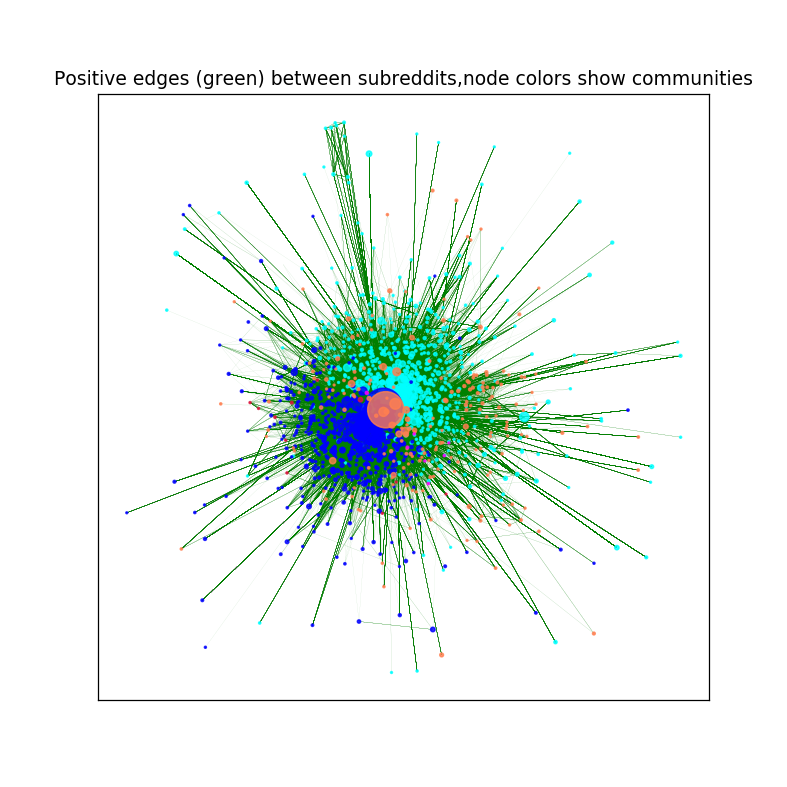

<IPython.core.display.Javascript object>


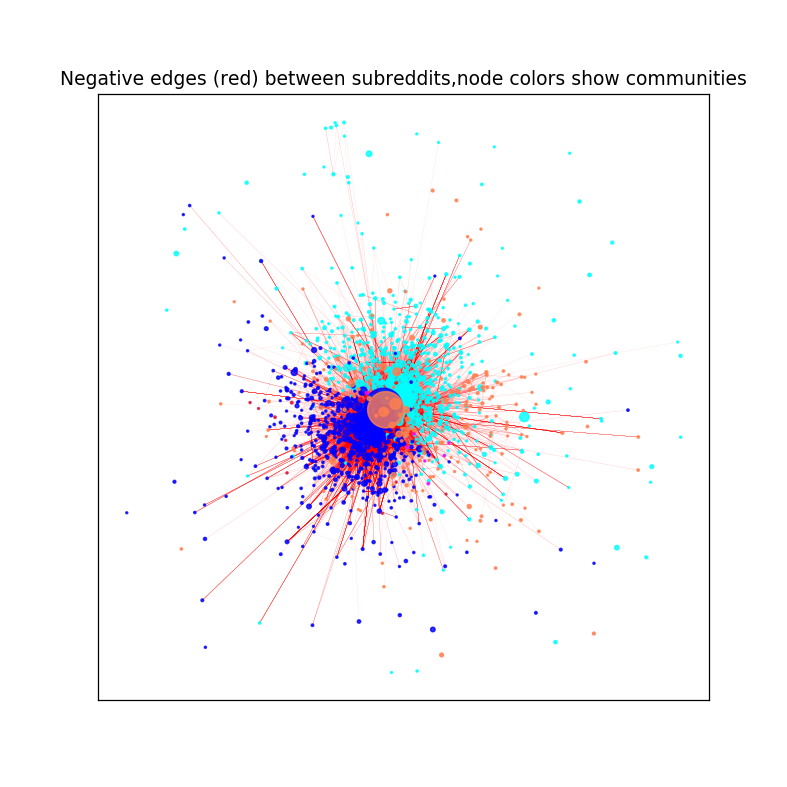

Text(0.5, 1.0, 'Negative edges (red) between subreddits,node colors show communities')

In [65]:
#  Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)  # positions for all nodes
counts_sum = sum(new_edge_counts.values()) / 10000

plt.figure(figsize = (7, 7)) 
draw_nodes()
nx.draw_networkx_edges(G, pos,
                       edgelist = pos_edges,
                       width = 0.05, alpha = 0.5, edge_color = 'g')
plt.title("Positive edges (green) between subreddits,\
node colors show communities")

plt.figure(figsize = (7, 7)) 
draw_nodes()
nx.draw_networkx_edges(G, pos,
                       edgelist = neg_edges,
                       width = 0.05, alpha = 0.5, edge_color = 'r')
plt.title("Negative edges (red) between subreddits,\
node colors show communities")

<IPython.core.display.Javascript object>


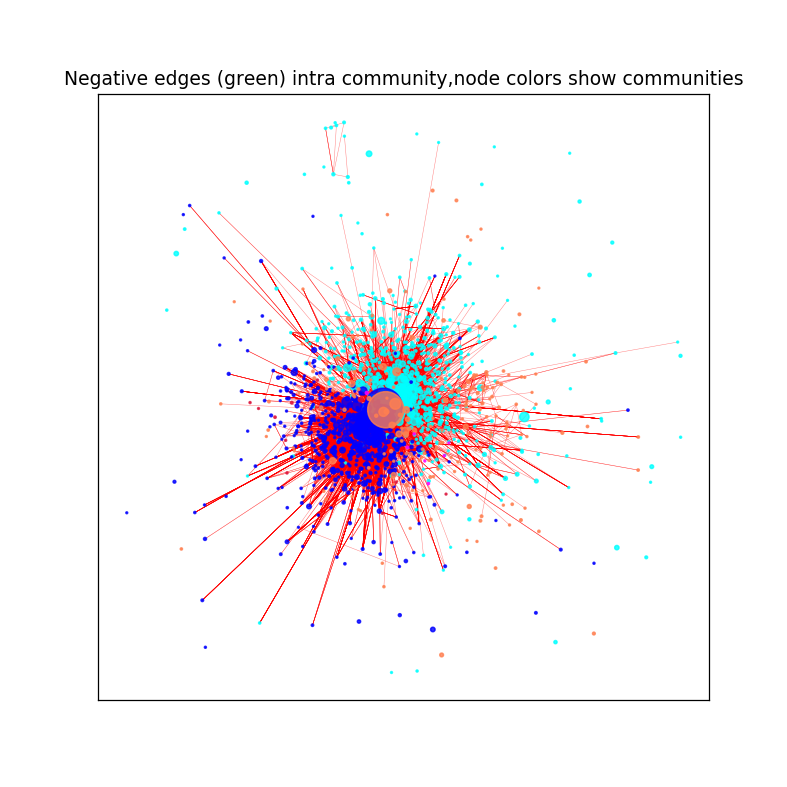

Text(0.5, 1.0, 'Negative edges (green) intra community,node colors show communities')

In [66]:
#  Fruchterman-Reingold force-directed algorithm
plt.figure(figsize = (7, 7)) 
draw_nodes()
nx.draw_networkx_edges(G, pos,
                       edgelist = neg_edge_same_community,
                       width = 0.3, alpha = 0.5, edge_color = 'r')
plt.title("Negative edges (green) intra community,\
node colors show communities")

<IPython.core.display.Javascript object>


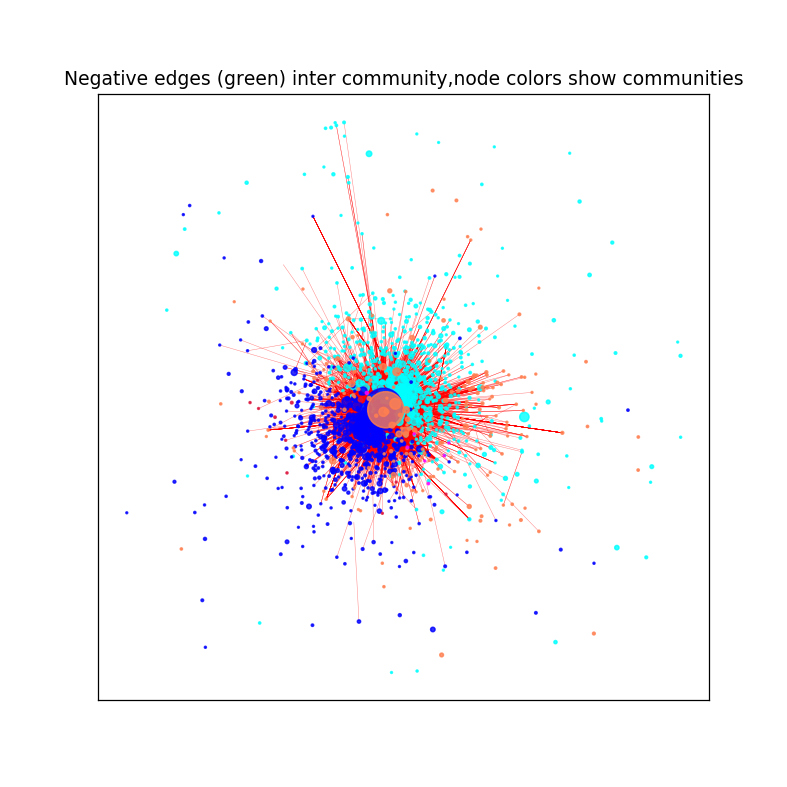

Text(0.5, 1.0, 'Negative edges (green) inter community,node colors show communities')

In [67]:
plt.figure(figsize = (7, 7)) 
draw_nodes()
nx.draw_networkx_edges(G, pos,
                       edgelist = neg_edge_diff_community,
                       width = 0.3, alpha = 0.5, edge_color = 'r')
plt.title("Negative edges (green) inter community,\
node colors show communities")